In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sb
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier


# fix random seed for more reproducibility and comparability
seed = 7
tf.random.set_seed(seed)

In [128]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_clean.csv')
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
853,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [129]:
all_inputs = df[df.loc[:, "Gender":].columns.values.tolist()].values

all_labels = df['Grade'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

# Generate the same cross validation strategy for all classifiers for better comparison
cross_validation = StratifiedKFold(n_splits=5)

# Classifier/Model Results dictionary
results = {}

#### Function to test the Model/Classifier

In [130]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

### Decision Tree With Hyperparameterization

In [131]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],}

result = test_model(decision_tree_classifier, parameter_grid)

results['Decision Tree'] = result

Best: 0.869312 using {'criterion': 'gini', 'max_depth': 4, 'max_features': 7, 'splitter': 'random'}
0.617326 (0.063855) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'best'}
0.605658 (0.048790) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'random'}
0.634612 (0.096121) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'best'}
0.605651 (0.042406) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 2, 'splitter': 'random'}
0.584605 (0.015620) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'best'}
0.636067 (0.106019) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 3, 'splitter': 'random'}
0.682592 (0.094836) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'best'}
0.616068 (0.069622) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 4, 'splitter': 'random'}
0.642908 (0.077407) with: {'criterion': 'gini', 'max_depth': 1, 'max

### Neural Network With Hyperparameterization

Based on: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [132]:
# Define the neural network architecture
def create_model(activation='relu'):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(200, activation=activation),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [133]:
# Define the neural network architecture
def create_model_without_compile(dropout_rate):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(200, activation='relu', input_shape=(n_features,)),
        keras.layers.Dense(200, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

In [134]:
def create_model_with_dropout(activation='relu', dropout_rate=0.7, neurons=200):
    n_features = df.columns.size - 1
    num_classes = df['Grade'].unique().size

    # Possible activations are tanh, sigmoid(Better for binary class classification), relu, softmax
    model = keras.Sequential([
        keras.layers.Dense(neurons, activation=activation, input_shape=(n_features,)),
        keras.layers.Dense(neurons, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

##### Tune Batch Size and Epochs

In [135]:
# # Create Model
# # model = KerasClassifier(model=create_model, verbose=0)
# model = KerasClassifier(model=create_model, verbose=0)

# # Define the grid search parameters
# # The batch size and number of epochs are hyperparameters that can be tuned for optimization
# batch_size = [10, 20, 40, 60, 80, 100]  # Batch size defines the number of samples that will be propagated through the network
# epochs = [10, 50, 100]  # Epochs defines the number times that the learning algorithm will work through the entire training dataset

# parameter_grid = dict(batch_size=batch_size, epochs=epochs)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

##### Output from batch_size and epochs tweaking
```
Best: 0.872814 using {'batch_size': 20, 'epochs': 50}
0.865789 (0.010049) with: {'batch_size': 10, 'epochs': 10}
0.865796 (0.010633) with: {'batch_size': 10, 'epochs': 50}
0.864640 (0.005806) with: {'batch_size': 10, 'epochs': 100}
0.801537 (0.097097) with: {'batch_size': 20, 'epochs': 10}
0.872814 (0.006767) with: {'batch_size': 20, 'epochs': 50}
0.865830 (0.013596) with: {'batch_size': 20, 'epochs': 100}
0.866973 (0.010119) with: {'batch_size': 40, 'epochs': 10}
0.865864 (0.032527) with: {'batch_size': 40, 'epochs': 50}
0.868149 (0.011980) with: {'batch_size': 40, 'epochs': 100}
0.859969 (0.009838) with: {'batch_size': 60, 'epochs': 10}
0.861193 (0.030020) with: {'batch_size': 60, 'epochs': 50}
0.861125 (0.016436) with: {'batch_size': 60, 'epochs': 100}
0.851816 (0.021059) with: {'batch_size': 80, 'epochs': 10}
0.864640 (0.009370) with: {'batch_size': 80, 'epochs': 50}
0.870468 (0.015508) with: {'batch_size': 80, 'epochs': 100}
0.834258 (0.024649) with: {'batch_size': 100, 'epochs': 10}
0.872800 (0.015948) with: {'batch_size': 100, 'epochs': 50}
0.863477 (0.007916) with: {'batch_size': 100, 'epochs': 100}

##### Tune optimization algorithm

In [136]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, metrics=['accuracy'], verbose=0)

# # Define the grid search parameters
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# parameter_grid = dict(optimizer=optimizer)

# result = test_model(model, parameter_grid)

# results['Neural Network'] = result

```
Best: 0.875133 using {'optimizer': 'Nadam'}
0.689786 (0.108668) with: {'optimizer': 'SGD'}
0.834211 (0.048834) with: {'optimizer': 'RMSprop'}
0.861172 (0.016843) with: {'optimizer': 'Adagrad'}
0.646308 (0.117676) with: {'optimizer': 'Adadelta'}
0.864654 (0.012314) with: {'optimizer': 'Adam'}
0.872821 (0.009925) with: {'optimizer': 'Adamax'}
0.875133 (0.013750) with: {'optimizer': 'Nadam'}


##### Tune Learning Rate and Momentum

In [137]:
# # Create Model
# model = KerasClassifier(model=create_model_without_compile, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# param_grid = dict(optimizer__learning_rate=learn_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.865837 using {'optimizer__learning_rate': 0.001}
0.865837 (0.017517) with: {'optimizer__learning_rate': 0.001}
0.863477 (0.019749) with: {'optimizer__learning_rate': 0.01}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.1}
0.548348 (0.063657) with: {'optimizer__learning_rate': 0.2}
0.579927 (0.001199) with: {'optimizer__learning_rate': 0.3}

##### Tune Neuron Activation Function

In [138]:
# # Create Model
# model = KerasClassifier(model=create_model, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# # Define the grid search parameters
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# param_grid = dict(model__activation=activation)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.873983 using {'model__activation': 'softplus'}
0.870488 (0.011188) with: {'model__activation': 'softmax'}
0.873983 (0.011982) with: {'model__activation': 'softplus'}
0.871651 (0.011019) with: {'model__activation': 'softsign'}
0.872807 (0.010116) with: {'model__activation': 'relu'}
0.870454 (0.008916) with: {'model__activation': 'tanh'}
0.870468 (0.004651) with: {'model__activation': 'sigmoid'}
0.869305 (0.008840) with: {'model__activation': 'hard_sigmoid'}
0.865830 (0.013596) with: {'model__activation': 'linear'}


##### Tune Dropout Regularization

In [139]:
# # Create Model
# model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", optimizer="Nadam", epochs=50, batch_size=20, verbose=0)

# activation = ["softplus"]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate)

# result = test_model(model, param_grid)

# results['Neural Network'] = result

```
Best: 0.875139 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.871624 (0.010696) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.0}
0.869291 (0.010429) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.1}
0.875133 (0.010984) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.2}
0.871624 (0.010036) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.3}
0.870461 (0.008832) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.4}
0.873977 (0.002939) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.5}
0.862288 (0.013843) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.6}
0.875139 (0.008024) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7}
0.866973 (0.004508) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.8}
0.866959 (0.010284) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.9}


##### Tune Number of Neurons

In [140]:
# Create Model
#model = KerasClassifier(model=create_model_with_dropout, loss="sparse_categorical_crossentropy", epochs=50, batch_size=20, verbose=0)

# learn_rate = [0.001, 0.01]
#activation = ["relu","softplus"]
#dropout_rate = [0.2, 0.7]
#neurons = [32, 64]
#optimizer = ['Nadam', 'Adam']
#param_grid = dict(model__activation=activation, model__dropout_rate=dropout_rate, model__neurons=neurons, optimizer=optimizer)

#result = test_model(model, param_grid)

#results['Neural Network'] = result

```
Best: 0.873977 using {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.865810 (0.014778) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 16}
0.871637 (0.009861) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 32}
0.873977 (0.006000) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 64}
0.872800 (0.008756) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 128}
0.862294 (0.012195) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 256}
0.870481 (0.002121) with: {'model__activation': 'softplus', 'model__dropout_rate': 0.7, 'model__neurons': 512}


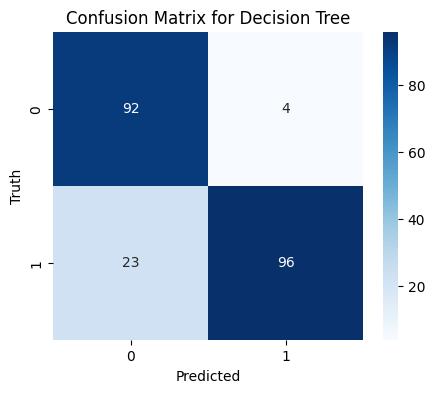

In [141]:
for key in results:
    # Predict the values from the validation dataset
    Y_pred = results[key].best_estimator_.predict(testing_inputs)

    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred)

    # Create the confusion matrix
    cm = confusion_matrix(testing_classes, Y_pred)

    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, cmap='Blues', fmt="d")
    plt.title('Confusion Matrix for ' + key)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

In [142]:
Grade = df.pop('Grade')
x_train, x_test, y_train, y_test = train_test_split(df, Grade, test_size=0.25)
RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)

RandomForestClassifier()

#### Random Forest with Hyperparemetrization

In [143]:
parameter_grid = {
    'n_estimators': [10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

result = test_model(RandomForest, parameter_grid)

results['Random Forest'] = result

Best: 0.878662 using {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
0.857643 (0.016779) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.870488 (0.009922) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
0.871658 (0.016007) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
0.868149 (0.013078) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.871658 (0.009596) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
0.871651 (0.008966) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
0.865823 (0.014191) with: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 

In [144]:
y_predicted = RandomForest.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

Text(33.22222222222222, 0.5, 'Truth')

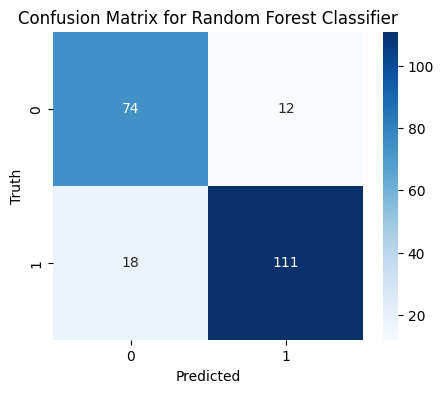

In [145]:
%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Naives Bayes Classifier with Hyperparameterization

#### Gaussian Naives Bayes


In [146]:
GaussianNaivesBayes = GaussianNB()
GaussianNaivesBayes.fit(x_train, y_train)

gnb_param_grid = {
    # There are no hyperparameters to tune for GaussianNB
}

gnb_grid_result = test_model(GaussianNaivesBayes, gnb_param_grid)

results['GaussianNaivesBayes'] = gnb_grid_result

Best: 0.802958 using {}
0.802958 (0.068119) with: {}


Text(33.22222222222222, 0.5, 'Truth')

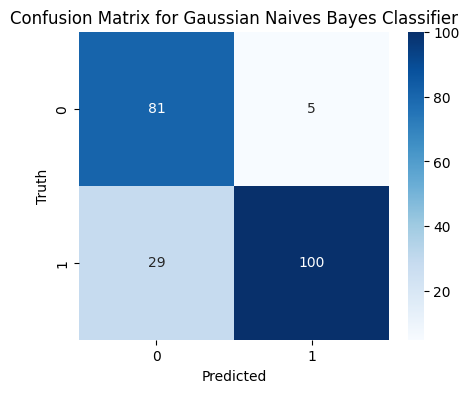

In [147]:
y_predicted = GaussianNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Gaussian Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Multinomial Naives Bayes

In [148]:
MultinomialNaivesBayes = MultinomialNB()
MultinomialNaivesBayes.fit(x_train, y_train)

mnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  
}

mnb_grid_result = test_model(MultinomialNaivesBayes, mnb_param_grid)

results['MultinomialNaivesBayes'] = mnb_grid_result

Best: 0.872827 using {'alpha': 2.0}
0.870488 (0.012911) with: {'alpha': 0.001}
0.870488 (0.012911) with: {'alpha': 0.01}
0.870488 (0.012911) with: {'alpha': 0.1}
0.871658 (0.012116) with: {'alpha': 0.5}
0.871658 (0.012116) with: {'alpha': 1.0}
0.872827 (0.014362) with: {'alpha': 2.0}
0.870502 (0.016894) with: {'alpha': 5.0}
0.869325 (0.015795) with: {'alpha': 10.0}


Text(33.22222222222222, 0.5, 'Truth')

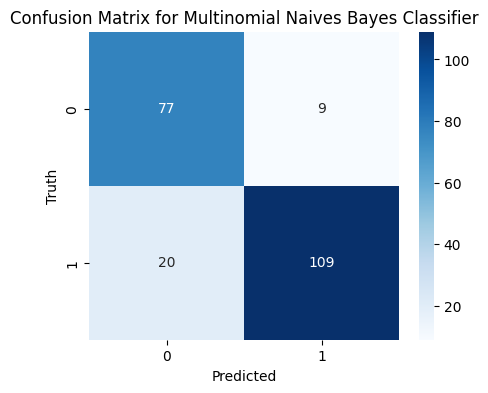

In [149]:
y_predicted = MultinomialNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Multinomial Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Bernoulli Naives Bayes

In [150]:
BernoulliNaivesBayes = BernoulliNB()
BernoulliNaivesBayes.fit(x_train, y_train)

bnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  
}

bnb_grid_result = test_model(BernoulliNaivesBayes, bnb_param_grid)

results['BernoulliNaivesBayes'] = bnb_grid_result

Best: 0.870502 using {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.01}
0.870502 (0.015209) with: {'alpha': 0.1}
0.870502 (0.015209) with: {'alpha': 0.5}
0.870495 (0.015273) with: {'alpha': 1.0}
0.870488 (0.012911) with: {'alpha': 2.0}
0.868149 (0.015469) with: {'alpha': 5.0}
0.863498 (0.016601) with: {'alpha': 10.0}


Text(33.22222222222222, 0.5, 'Truth')

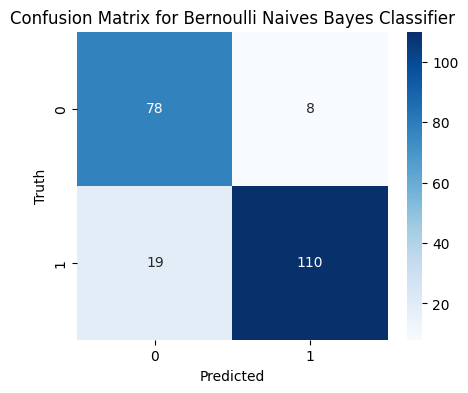

In [151]:
y_predicted = BernoulliNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Bernoulli Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Support Vector Machine (SVM) with Hyperparameterization

In [152]:
svm = SVC(probability=True)
svm.fit(x_train, y_train)

parameter_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],         
    'degree': [2, 3, 4],   
    'class_weight': [None, 'balanced'], 
    'probability': [True]             
}
result = test_model(svm, parameter_grid)

results['Support Vector Machine'] = result

Best: 0.870502 using {'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'auto', 'probability': True}
0.728145 (0.031240) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'probability': True}
0.739834 (0.028338) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'probability': True

Text(33.22222222222222, 0.5, 'Truth')

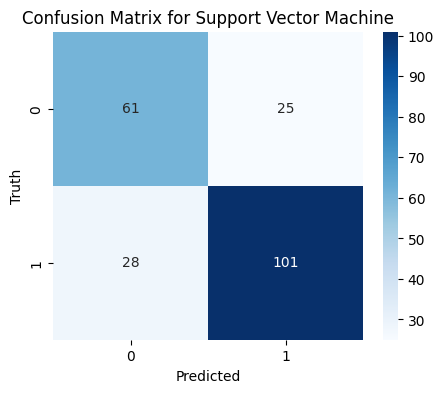

In [153]:
y_predicted = svm.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### K Nearest Neighboors

In [154]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

parameter_grid = {
    'n_neighbors': [3, 5, 7, 9],          
    'weights': ['uniform', 'distance'],   
    'metric': ['euclidean', 'manhattan', 'minkowski'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': [30, 40, 50],            
    'p': [1, 2]                           
}
result = test_model(knn, parameter_grid)

results['K Nearest Neighbors'] = result

Best: 0.835475 using {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.800503 (0.017783) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'l

Text(33.22222222222222, 0.5, 'Truth')

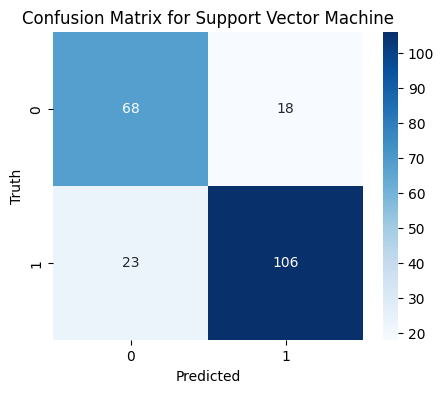

In [155]:
y_predicted = knn.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Truth')